In [1]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import get_moon

from astropy import units as u
from astropy.time import Time
from astropy.time import TimeDelta
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator


import ephem #Used for phase of the moon
import numpy as np
import seaborn as sns

In [2]:
OBS_LONG =   7.081489000000E+01 # [deg] Observatory east longitude            
OBS_LAT  =  -3.016606000000E+01 # [deg] Observatory latitude                     
OBS_ELEV =   2.215000000000E+03 # [m] Observatory elevation  

In [3]:
loc = EarthLocation(lat=OBS_LONG*u.deg, lon=OBS_LONG*u.deg, height=OBS_ELEV*u.m) 
print loc

(691092.1218293593, 1986208.0997949247, 6003618.150203419) m


In [4]:
#TEST TO SEE WHETHER I CAN GET THE MOON DISTANCE TO AGREE WITH THE INT CALCULATOR

date = '2017-08-15T05:00:00'
t = Time(date, format='isot', scale='utc')
t.mjd

57980.208333333336

In [5]:
t2 = Time(t.mjd, format='mjd', scale='utc')
print t2.isot

2017-08-15T05:00:00.000


In [6]:
#This is in the GCRS frame.  The RA, DEC are correct.  Need to create a new SkyCoord with the proper ICRS frame.
moon = get_moon(t, loc)
moon = SkyCoord(moon.ra, moon.dec, frame = 'icrs')

#Test against PyEphem
m     = ephem.Moon(t.iso)
print t.iso

print type(moon)
print moon.frame

print moon.ra, moon.dec

print m.a_ra,m.a_dec

2017-08-15 05:00:00.000
<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
<ICRS Coordinate: (ra, dec) in deg
    (53.06772486, 12.87241748)>
53d04m03.8095s 12d52m20.7029s
3:33:22.82 13:44:04.7


In [7]:
#Turns out there is a definite difference between the two
SNX3 = SkyCoord('02h25m48.00s', '-04d36m00.09s', frame='icrs')
SNS2 = SkyCoord('02h44m46.66s', '-00d59m18.2s', frame='icrs')

print SNX3.ra, SNX3.dec
print type(SNX3)

print moon.separation(SNX3)
print moon.separation(SNS2)

#moon = SkyCoord('51d03m00.5091s', '12d22m15.7698s', frame='icrs')
#type(moon)
#print moon.ra,moon.dec
#print moon.frame

#print moon.separation(SNX3)

36d27m00s -4d36m00.09s
<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
24d02m16.3391s
18d11m24.1534s


In [8]:
newtime = t
sec     = 60*60*24
arr    = []

for i in range(180):
    #Compute the time of the new epoch
    newtime = newtime + TimeDelta(sec, format='sec')
    a     = newtime.iso
    
    #Uses PyEphem, determine the moon phase, position, and separation from X3
    m     = ephem.Moon(a)
    phase = m.phase
    
    moon1 = SkyCoord(str(m.ra), str(m.dec), unit=(u.hourangle, u.deg))
    sep1  = moon1.separation(SNX3)
    
    #Do separation using astropy.get_moon
    #This takes much longer than ephem, so am skipping this for now
    #Difference in moon angle is <1 degree
    #
    #moon2 = get_moon(newtime, loc)
    #moon2 = SkyCoord(moon2.ra, moon2.dec, frame = 'icrs')
    #sep2  = moon2.separation(SNX3)
    
    temp = [newtime.mjd, phase, sep1.value] #, sep2.value]
    #print temp
    arr.append(temp)
    
arr = np.array(arr) 

This now works.  I can compute the moon-distance for any mjd or epoch.  
  
Next step is to import Data Quality table.  I want to plot:

PSF vs. Moon Distance

(i expect this to be roughly a scatter plot)

Sky Brightness vs. Moon Distance

(somewhat strong correlation with scatter, as you get brighter as you get closer to the moon)

Want to have the result be Pass/Fail for DQ; or maybe t_eff or SNR?



In [9]:
print len(arr)

180


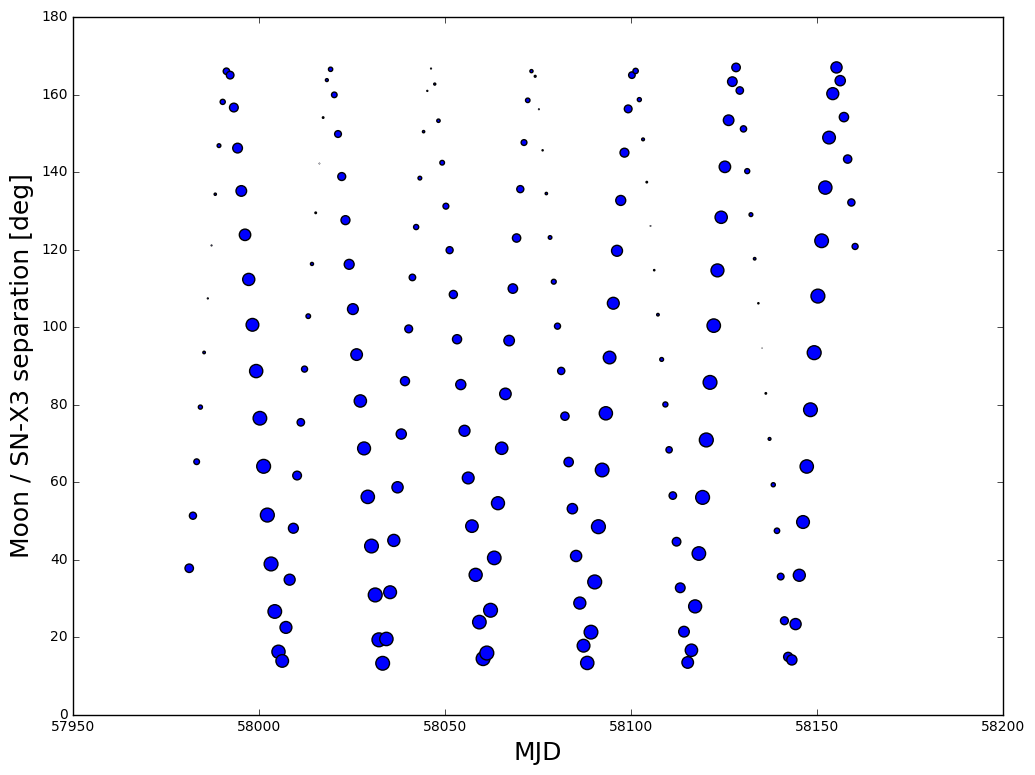

In [10]:
f, ax1 = plt.subplots(1, figsize=(12,9))

size = arr[:,1]
ax1.scatter(arr[:,0], arr[:,2], marker='o', c='b', s=size, label='the data')

ax1.set_xlabel('MJD',fontsize=18)
ax1.set_ylabel('Moon / SN-X3 separation [deg]',fontsize=18)

plt.show()


In [11]:
#Okay, looks like I can make moon distance and phase plots
#Now to download the data quality and compare

import easyaccess as ea
import pandas as pd

qual = pd.read_csv('sn_status.txt', sep=" ", header=None)
qual.columns = ["a", "NITE", "FIELD", "BAND", "ATT", "EXPNUM", "STATUS", "PSF",  
                "AIR", "FAKE", "zPSF", "SNR20", "EFF50", "ACCEPT"]


In [12]:
qual.query('NITE > 20170801')

a      NITE  FIELD BAND ATT  EXPNUM  STATUS   PSF   AIR   FAKE  zPSF  \
0    3069  20170829  SN-C1    g   1  673413  ACTIVE  1.48  1.18   52.1  1.22   
1    3069  20170829  SN-C1    i   1  673415  ACTIVE  1.44  1.16   14.1  1.32   
2    3069  20170829  SN-C1    r   1  673414  ACTIVE  1.48  1.16   88.1  1.30   
3    3069  20170829  SN-C1    z   1  673416  ACTIVE  1.37  1.05   12.8  1.38   
4    3069  20170829  SN-X1    g   1  673388  ACTIVE  2.01  1.45   67.7  1.46   
5    3069  20170829  SN-X1    i   1  673390  ACTIVE  1.78  1.41    3.8  1.45   
6    3069  20170829  SN-X1    r   2  673389    JUNK   NaN  1.42    NaN   NaN   
7    3069  20170829  SN-X1    z   1  673391  ACTIVE  1.59  1.38    7.8  1.36   
8    3069  20170829  SN-X2    g   1  673453  ACTIVE  1.36  1.15  100.0  1.14   
9    3069  20170829  SN-X2    i   1  673455  ACTIVE  1.16  1.16   96.9  1.06   
10   3069  20170829  SN-X2    r   1  673454  ACTIVE  1.26  1.16   90.4  1.11   
11   3069  20170829  SN-X2    z   1  673456  ACTIVE  1.13  1.17   91.2  1.06   
12   3069  20170829  SN-X3    i   2  673395    JUNK   NaN  1.33    NaN   NaN   
13   3064  20170828  SN-C1    g   1  673089  ACTIVE  2.70  1.36   97.9  2.03   
14   3064  20170828  SN-C1    i   1  673091  ACTIVE  2.22  1.33   91.8  1.87   
15   3064  20170828  SN-C1    r   1  673090  ACTIVE  2.18  1.34  100.0  1.76   
16   3064  20170828  SN-C1    z   1  673092  ACTIVE  2.32  1.30   48.8  2.04   
17   3064  20170828  SN-C2    g   1  673095  ACTIVE  2.53  1.27  100.0  1.98   
18   3064  20170828  SN-C2    i   1  673097  ACTIVE  1.81  1.25   96.2  1.58   
19   3064  20170828  SN-C2    r   1  673096  ACTIVE  2.20  1.26   99.0  1.84   
20   3064  20170828  SN-C2    z   1  673098  ACTIVE  1.75  1.23   86.0  1.60   
21   3064  20170828  SN-E1    g   1  673101  ACTIVE  2.14  1.03  100.0  1.91   
22   3064  20170828  SN-E1    i   1  673103  ACTIVE  1.87  1.03   99.1  1.84   
23   3064  20170828  SN-E1    r   1  673102  ACTIVE  1.84  1.03  100.0  1.74   
24   3064  20170828  SN-E1    z   1  673104  ACTIVE  2.25  1.04   75.0  2.28   
25   3064  20170828  SN-E2    g   1  673107  ACTIVE  2.06  1.04   98.3  1.83   
26   3064  20170828  SN-E2    i   1  673109  ACTIVE  2.04  1.05   92.7  1.98   
27   3064  20170828  SN-E2    r   1  673108  ACTIVE  2.10  1.04   98.9  1.97   
28   3064  20170828  SN-E2    z   1  673110  ACTIVE  1.93  1.05   88.5  1.94   
29   3064  20170828  SN-X1    g   1  673113  ACTIVE  1.91  1.12  100.0  1.61   
..    ...       ...    ...  ...  ..     ...     ...   ...   ...    ...   ...   
87   3037  20170820  SN-S2    z   2  670023  ACTIVE  1.70  1.34   93.0  1.48   
88   3037  20170820  SN-X1    g   2  670014  ACTIVE  1.81  1.30  100.0  1.41   
89   3037  20170820  SN-X1    i   1  670016  ACTIVE  1.54  1.28  100.0  1.33   
90   3037  20170820  SN-X1    r   1  670015  ACTIVE  1.65  1.29  100.0  1.36   
91   3037  20170820  SN-X1    z   1  670017  ACTIVE  1.52  1.26  100.0  1.37   
92   3037  20170820  SN-X2    g   1  670036  ACTIVE  1.71  1.14  100.0  1.43   
93   3037  20170820  SN-X2    i   1  670038  ACTIVE  1.50  1.13   98.8  1.39   
94   3037  20170820  SN-X2    r   1  670037  ACTIVE  1.54  1.13  100.0  1.38   
95   3037  20170820  SN-X2    z   1  670039  ACTIVE  1.55  1.12   98.6  1.50   
96   3037  20170820  SN-X3    g   1  670068  ACTIVE  1.91  1.14   85.9  1.60   
97   3035  20170819  SN-E1    g   1  669479  ACTIVE  1.55  1.15  100.0  1.29   
98   3035  20170819  SN-E1    i   1  669481  ACTIVE  1.30  1.14   98.8  1.20   
99   3035  20170819  SN-E1    r   1  669480  ACTIVE  1.39  1.14  100.0  1.24   
100  3035  20170819  SN-E1    z   1  669482  ACTIVE  1.31  1.12   95.8  1.26   
101  3035  20170819  SN-E2    g   1  669492  ACTIVE  1.96  1.10   98.1  1.67   
102  3035  20170819  SN-E2    i   1  669494  ACTIVE  1.74  1.09   98.9  1.65   
103  3035  20170819  SN-E2    r   1  669493  ACTIVE  1.92  1.10   98.8  1.74   
104  3035  20170819  SN-E2    z   1  669495  ACTIVE  1.33  1.09   96.4  1.31   
105  303

In [13]:
qual.query('EXPNUM == 575053')

a      NITE  FIELD BAND ATT  EXPNUM STATUS  PSF   AIR  FAKE  zPSF  \
1096  2529  20160914  SN-C3    i   2  575053   JUNK  NaN  1.25   NaN   NaN   

      SNR20  EFF50 ACCEPT  
1096    NaN   28.0  False

In [14]:
print len(qual)
t = qual.query("ACCEPT == 'True'")
print len(t)

4924
4171


In [15]:
connection =ea.connect()
cursor     =connection.cursor()

#query = "select e.field, e.nite, e.band, e.mjd_obs, a.* from EXPOSURE e JOIN " \
#    "(select expnum, t_eff, SKYBRIGHTNESS, FWHM_ASEC, accepted, LASTCHANGED_TIME from" \
#    " (select expnum, t_eff, SKYBRIGHTNESS, FWHM_ASEC, accepted, LASTCHANGED_TIME," \
#    " max(LASTCHANGED_TIME) over (partition by expnum) max_time from FIRSTCUT_EVAL) " \
#    " where LASTCHANGED_TIME = max_time) a " \
#    "on a.expnum = e.expnum and e.field LIKE 'SN-%' and e.exptime > 30 order by a.expnum;"

query = "select expnum, radeg, decdeg, field, nite, band, mjd_obs " \
        "from EXPOSURE where FIELD like 'SN-%' and mjd_obs > 0"

print query
#QQ=cursor.execute(query) #execute query
#QQ.description
#header = [item[0] for item in cursor.description]
#rows = cursor.fetchall()  ## Bring the data
#cols = np.array(zip(*rows))

exp=connection.query_to_pandas(query) #one line!

Connecting to DB ** desoper ** ...
select expnum, radeg, decdeg, field, nite, band, mjd_obs from EXPOSURE where FIELD like 'SN-%' and mjd_obs > 0


In [16]:
print exp.columns
print qual.columns

Index([u'EXPNUM', u'RADEG', u'DECDEG', u'FIELD', u'NITE', u'BAND', u'MJD_OBS'], dtype='object')
Index([u'a', u'NITE', u'FIELD', u'BAND', u'ATT', u'EXPNUM', u'STATUS', u'PSF', u'AIR', u'FAKE', u'zPSF', u'SNR20', u'EFF50', u'ACCEPT'], dtype='object')


In [17]:
exp.query('EXPNUM == 575053')

EXPNUM      RADEG  DECDEG  FIELD      NITE BAND       MJD_OBS
4871  575053  52.648396   -28.1  SN-C3  20160914    i  57646.231115

In [32]:
data = pd.merge(qual, exp, how='left', \
                   left_on='EXPNUM', right_on='EXPNUM', suffixes=('_qual','_exp'))
print 'Length of all entries: ',len(data)

#alldata = alldata.query("FIT != 0")
#print 'Length of all entries matched to only actual data: ',len(alldata)

#Remove the fields that have XXXX placeholders in the photometry file from the left join 
#alldata = alldata[alldata.FIELD != 'XXXX']
#print len(alldata)

Length of all entries:  4924


In [ ]:
#data

In [33]:
new_data = data.assign(MOONDIST = np.ones(len(data.index)), MOONPHASE = np.ones(len(data.index)))

for i in range(len(new_data)):
    item = new_data.iloc[i]
    if item['MJD_OBS'] > 0:
        #Having Trouble getting rid of damn NaN
        t = Time(item['MJD_OBS'], format='mjd', scale='utc')
    
        if i%200 == 0:
            print i
        
        m     = ephem.Moon(t.iso)
        phase = m.phase
    
        moon  = SkyCoord(str(m.ra), str(m.dec), unit=(u.hourangle, u.deg))
        field = SkyCoord(item['RADEG'], item['DECDEG'], frame='icrs', unit='deg')
        sep   = field.separation(moon)

        new_data.loc[i, 'MOONDIST']  = sep.value
        new_data.loc[i, 'MOONPHASE'] = phase

0
200
400
600


KeyboardInterrupt: 

In [21]:
to_drop = []

for i in range(len(new_data)):
    item = new_data.iloc[i]
    mjd  = item['MJD_OBS']
    if np.isnan(mjd):
        print i,mjd
        to_drop.append(i)
        
print len(new_data)
print len(to_drop)
for i in reversed(to_drop):
    print i
    new_data.drop(new_data.index[i])

print len(new_data)

4479 nan
4924
1
4479
4924


753 4171


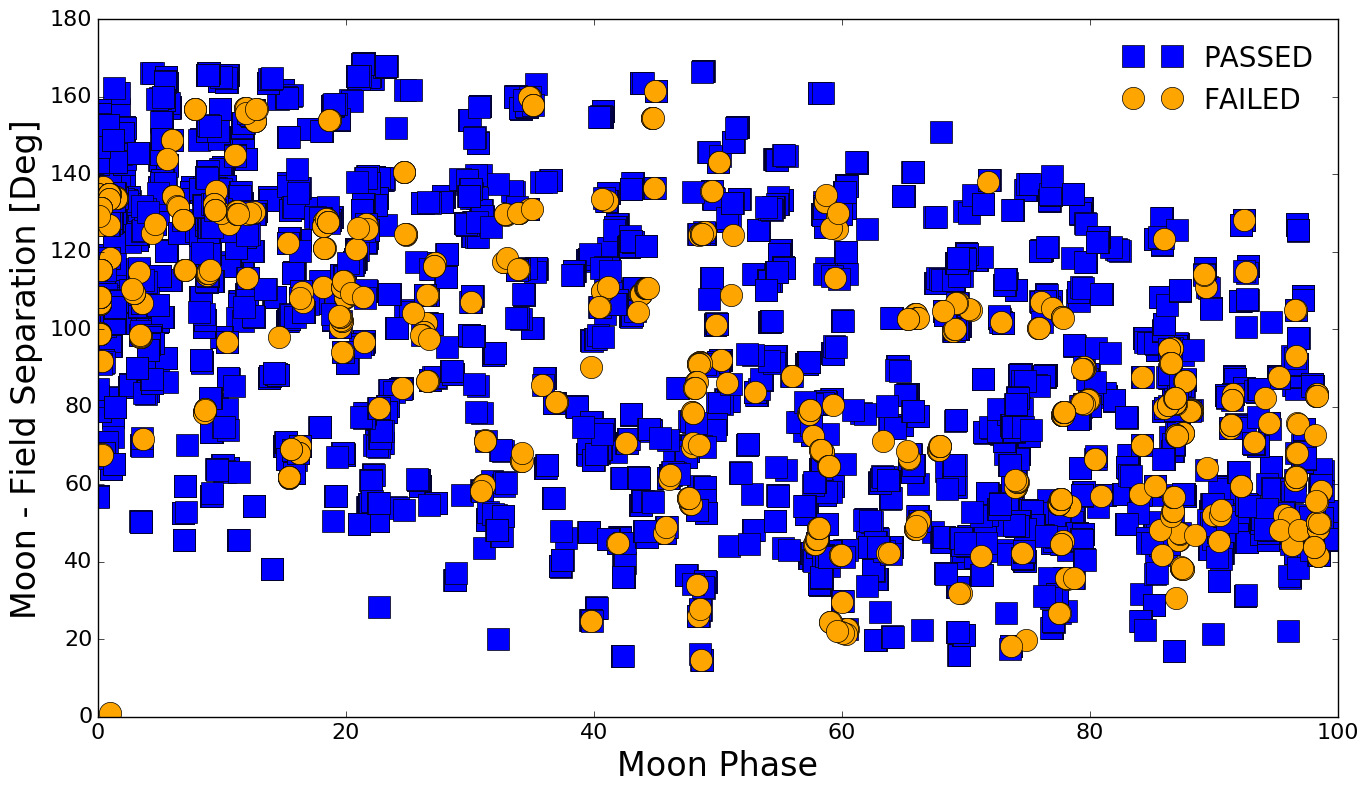

In [22]:
f, ax1 = plt.subplots(1, figsize=(16,9))

t1 = new_data.query("ACCEPT != 'True'")
t2 = new_data.query("ACCEPT == 'True'")

ax1.plot(t2['MOONPHASE'], t2['MOONDIST'], 's', color='blue',  label='PASSED', markersize=16)
ax1.plot(t1['MOONPHASE'], t1['MOONDIST'], 'o', color='orange', label='FAILED', markersize=16)

ax1.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('Moon - Field Separation [Deg]',fontsize=24)
ax1.set_xlabel('Moon Phase',fontsize=24)

plt.legend(loc='upper right',frameon=False,fontsize=20)


print len(t1),len(t2)
plt.show()

0 210
1 209
2 212
3 198
753 4171


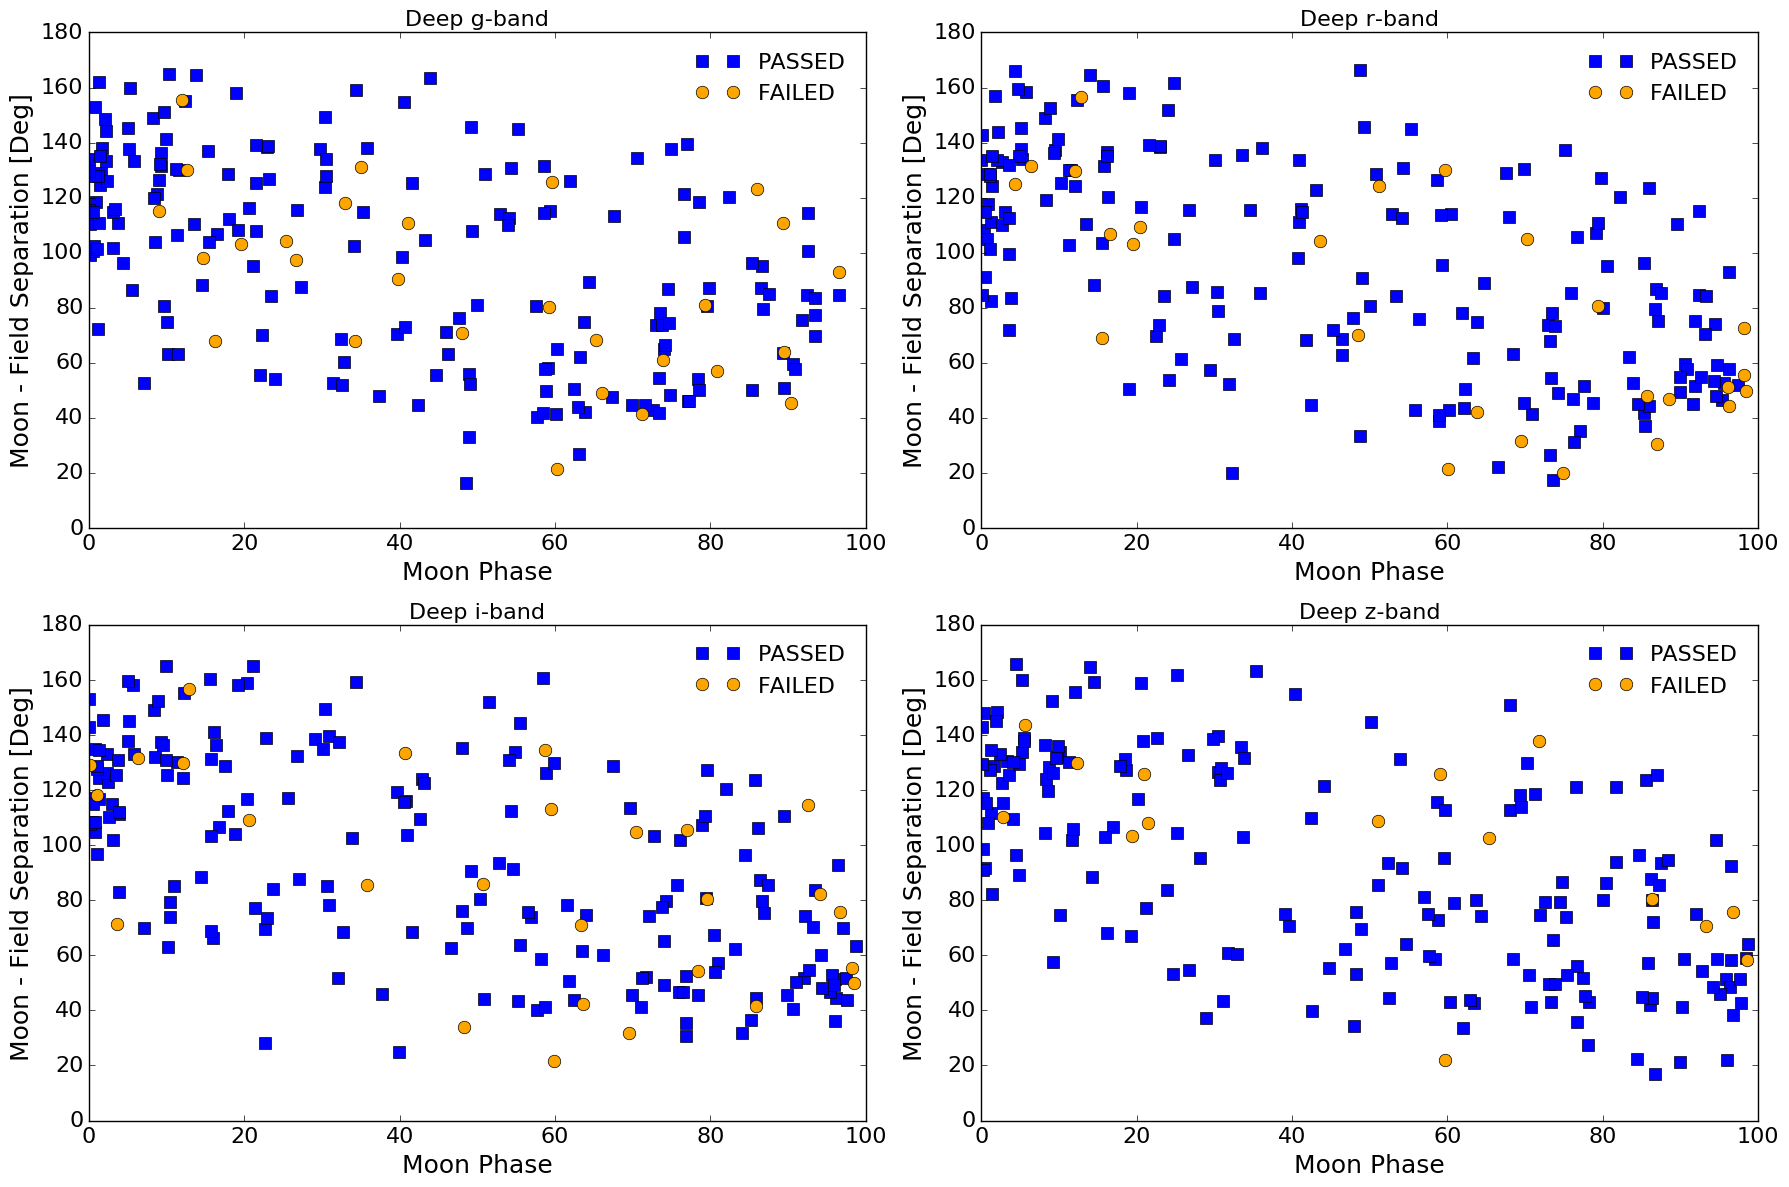

In [23]:
f, ax1 = plt.subplots(2,2, figsize=(18,12))

t1 = new_data.query("ACCEPT != 'True'")
t2 = new_data.query("ACCEPT == 'True'")

ax2 = ax1.flatten()
band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    color = band[i]

    temp2 = t2.query("BAND_qual == '{0}' and (FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3')".format(color))
    temp1 = t1.query("BAND_qual == '{0}' and (FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3')".format(color))
    print i,len(temp2)+len(temp1)
    
    
    ax.plot(temp2['MOONPHASE'], temp2['MOONDIST'], 's', color='blue',  label='PASSED', markersize=9)
    ax.plot(temp1['MOONPHASE'], temp1['MOONDIST'], 'o', color='orange', label='FAILED', markersize=9)

    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel('Moon - Field Separation [Deg]',fontsize=18)
    ax.set_xlabel('Moon Phase',fontsize=18)

    ax.set_ylim(0,180)
    
    ax.legend(loc='upper right',frameon=False,fontsize=16)
    ax.set_title('Deep {0}-band'.format(color),fontsize=16)

print len(t1),len(t2)
plt.tight_layout()
plt.show()

888
4036
753 4171


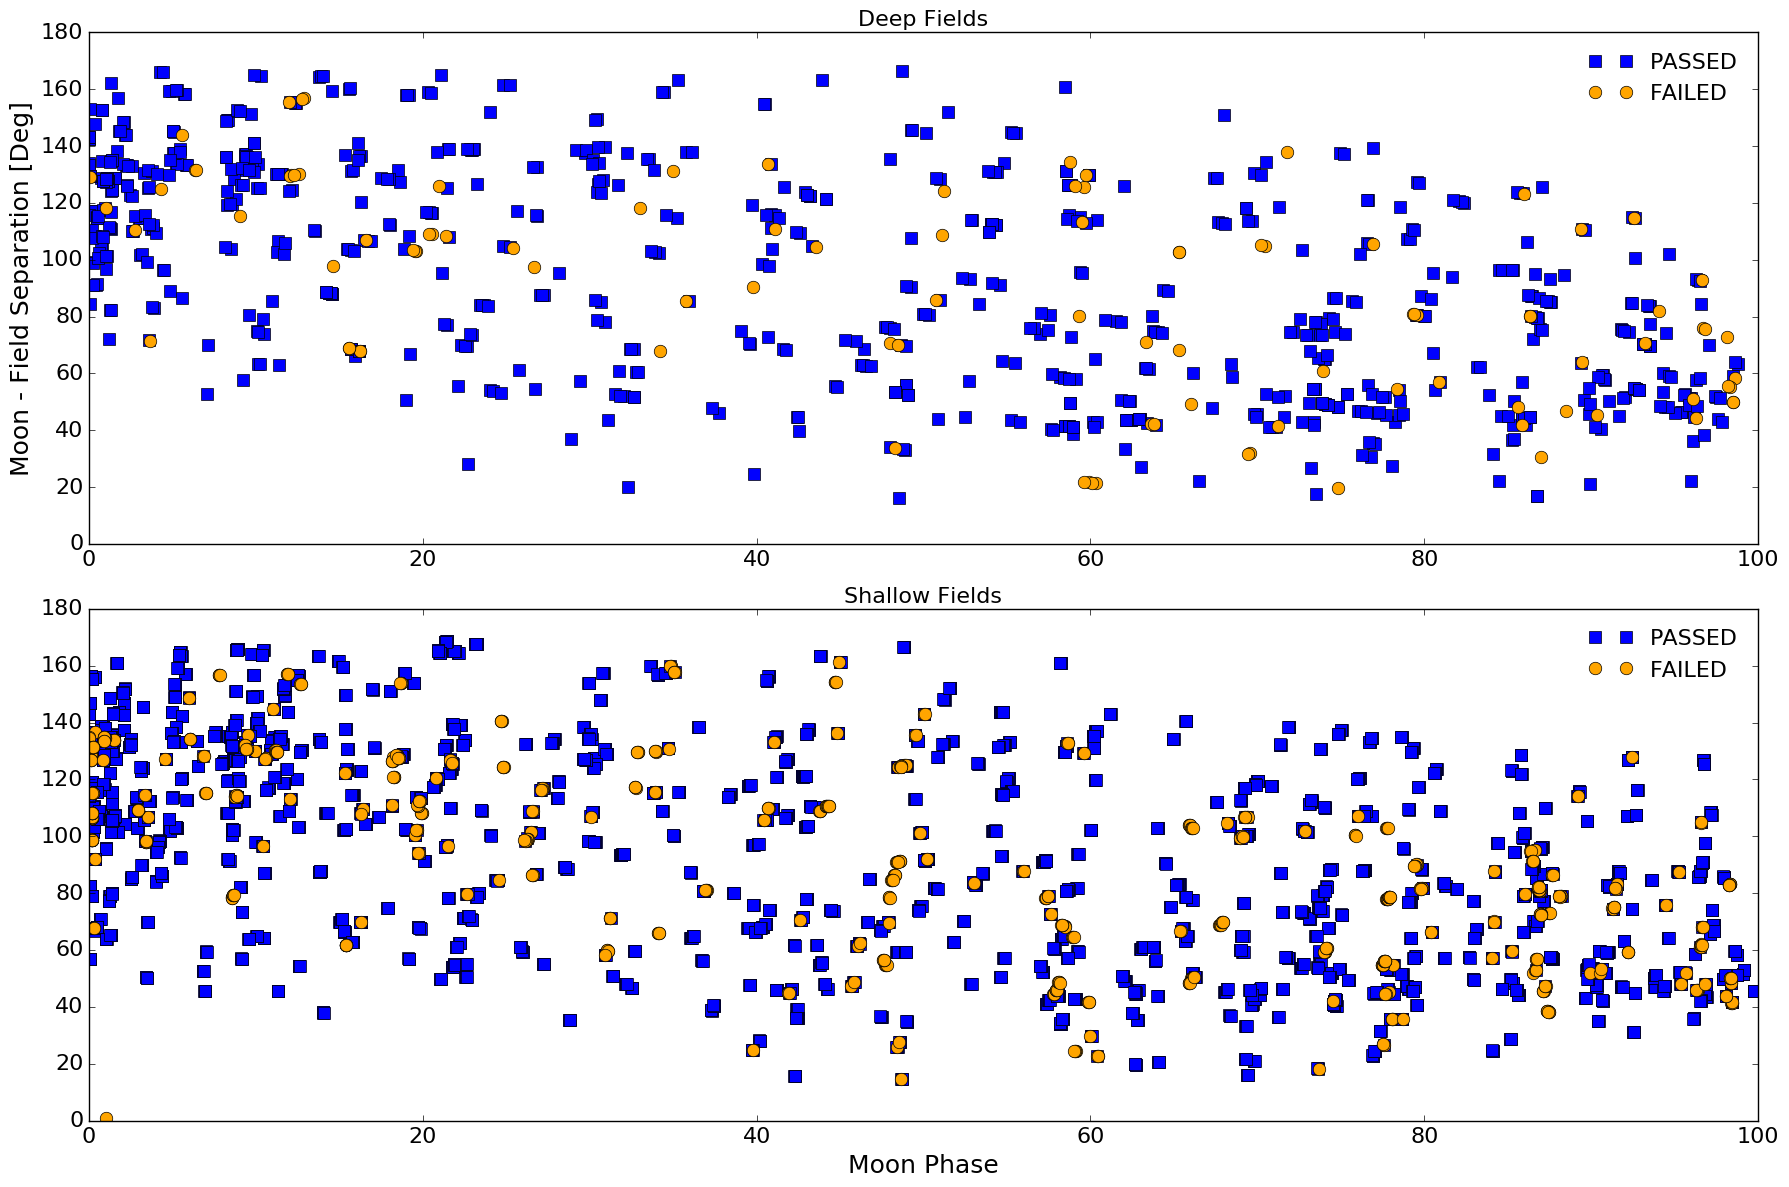

In [24]:
f, [ax1, ax2] = plt.subplots(2,1, figsize=(18,12))

t1 = new_data.query("ACCEPT != 'True'")
t2 = new_data.query("ACCEPT == 'True'")

temp2_1 = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
temp1_1 = t1.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
print len(temp2_1)+len(temp1_1)

temp2_2 = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")
temp1_2 = t1.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")
print len(temp2_2)+len(temp1_2)

ax1.plot(temp2_1['MOONPHASE'], temp2_1['MOONDIST'], 's', color='blue',  label='PASSED', markersize=9)
ax1.plot(temp1_1['MOONPHASE'], temp1_1['MOONDIST'], 'o', color='orange', label='FAILED', markersize=9)

ax2.plot(temp2_2['MOONPHASE'], temp2_2['MOONDIST'], 's', color='blue',  label='PASSED', markersize=9)
ax2.plot(temp1_2['MOONPHASE'], temp1_2['MOONDIST'], 'o', color='orange', label='FAILED', markersize=9)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('Moon - Field Separation [Deg]',fontsize=18)
ax2.set_xlabel('Moon Phase',fontsize=18)
ax1.set_ylabel('Moon - Field Separation [Deg]',fontsize=18)
ax2.set_xlabel('Moon Phase',fontsize=18)

ax1.legend(loc='upper right',frameon=False,fontsize=16)
ax2.legend(loc='upper right',frameon=False,fontsize=16)
ax1.set_title('Deep Fields'.format(color),fontsize=16)
ax2.set_title('Shallow Fields'.format(color),fontsize=16)

print len(t1),len(t2)
plt.tight_layout()
plt.show()

In [25]:
#Question 1:  How could the distance be <10 degrees?  445 Objects!
close = new_data.query("MOONPHASE > 95 and MOONDIST < 50 and BAND_qual == 'g'" )
close.sort_values(by='MOONDIST')

a  NITE_qual FIELD_qual BAND_qual   ATT  EXPNUM  STATUS   PSF   AIR   FAKE  zPSF  SNR20  EFF50 ACCEPT      RADEG     DECDEG FIELD_exp  NITE_exp BAND_exp       MJD_OBS   MOONDIST  MOONPHASE
2391  1644   20150830      SN-X2         g     1  469206  ACTIVE  1.48  1.10   91.3  1.27   55.9   22.7   True  35.664500  -6.412100     SN-X2  20150830        g  57265.377561  35.935052  96.159363
4319  None   20131215      SN-X2         g  None  265096    None   NaN  1.12    NaN   NaN    NaN   28.0   None  35.664500  -6.412100     SN-X2  20131215        g  56642.100632  41.473846  98.403915
4315  1561   20131215      SN-X1         g     1  265102  ACTIVE  1.61  1.17   65.8  1.32   54.8   22.5   True  34.475700  -4.929500     SN-X1  20131215        g  56642.114100  41.649607  98.435249
2387  1644   20150830      SN-S2         g     1  469178  ACTIVE  1.90  1.33   44.6  1.46   39.7   22.2   True  41.194400  -0.988400     SN-S2  20150830        g  57265.286087  42.245398  96.579079
2379  1644   20150830      SN-E1         g     1  469153  ACTIVE  1.54  1.09   81.8  1.33   57.2   22.6   True   7.874400 -43.009600     SN-E1  20150830        g  57265.209381  43.347748  96.912964
4475  1543   20131118      SN-X1         g     1  255857  ACTIVE  1.34  1.40  100.0  0.99   87.3   23.3   True  34.475700  -4.929500     SN-X1  20131118        g  56615.022828  43.698337  98.092392
2383  1644   20150830      SN-E2         g     1  469159  ACTIVE  1.64  1.08   83.7  1.42   56.3   22.8   True   9.500000 -43.998000     SN-E2  20150830        g  57265.222927  44.640947  96.855209
4482  1542   20131117      SN-C1         g     1  255449  ACTIVE  1.19  1.25   90.3  0.95   72.7   22.9   True  54.274300 -27.111600     SN-C1  20131117        g  56614.073124  45.659562  99.781357
672   2722   20161115      SN-X2         g     2  593070    JUNK   NaN  1.15    NaN   NaN    NaN   28.0  False  35.666833  -6.411294     SN-X2  20161115        g  57708.091205  45.812803  96.321175
668   2722   20161115      SN-X1         g     2  593064    JUNK   NaN  1.19    NaN   NaN    NaN   28.0  False  34.477396  -4.930694     SN-X1  20161115        g  57708.077747  45.858279  96.381508
2748  1800   20150102      SN-X1         g     1  393853  ACTIVE  1.62  1.24   78.0  1.29   60.0   22.5   True  34.475700  -4.929500     SN-X1  20150102        g  57025.086005  48.089131  95.345505
3139  1703   20141104      SN-C1         g     1  375483  ACTIVE  2.52  1.31   60.3  1.94   52.8   22.3   True  54.274300 -27.111600     SN-C1  20141104        g  56966.352810  48.146652  96.836235
4297  1561   20131215      SN-C1         g     1  265090    JUNK   NaN  1.01    NaN   NaN    NaN   28.0  False  54.274300 -27.111600     SN-C1  20131215        g  56642.083620  48.306758  98.363861
4456  1543   20131118      SN-C1         g     1  255888  ACTIVE  1.29  1.14   85.2  1.08   58.9   22.8   True  54.274300 -27.111600     SN-C1  20131118        g  56615.096090  49.669376  97.893425

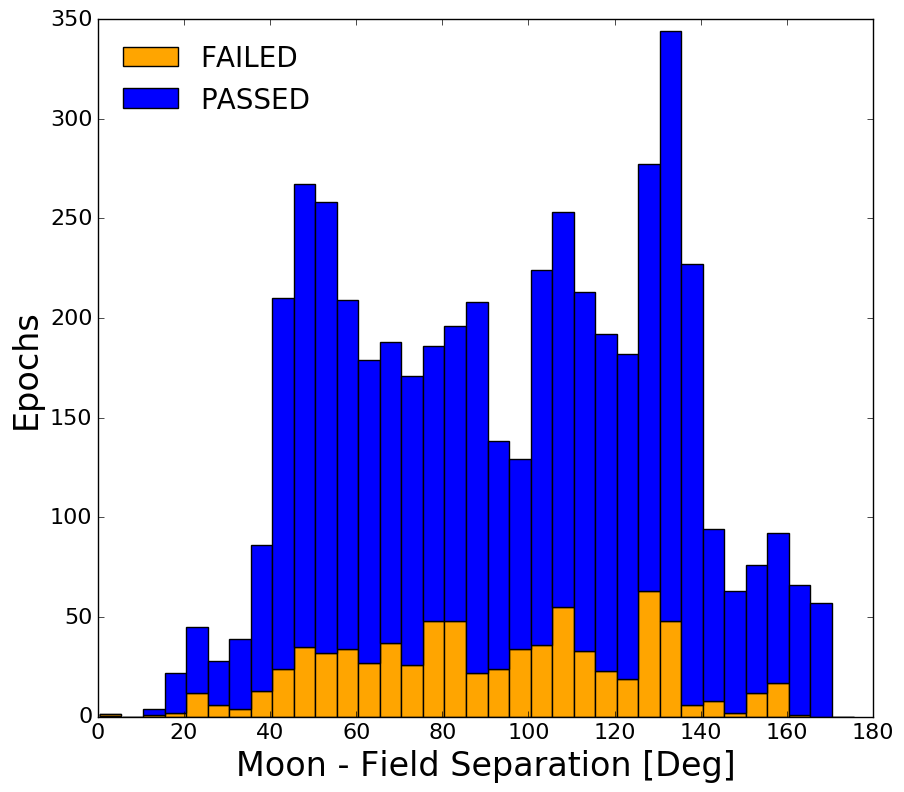

In [26]:
f, ax1 = plt.subplots(1, figsize=(10,9))

#t2['MOONDIST'].hist(bins=np.arange(0,180,5), color='blue', label='PASSED')
#t1['MOONDIST'].hist(bins=np.arange(0,180,5), color='orange', label='FAILED')
t1 = new_data.query("ACCEPT != 'True'")
t2 = new_data.query("ACCEPT == 'True'")

ax1.hist([t1['MOONDIST'], t2['MOONDIST']], bins=np.arange(0,180,5), color=['orange','blue'], \
            label=['FAILED','PASSED'], stacked='True', width=5.0)
 
#ax1.plot(t1['MOONDIST'],np.cumsum(t1['MOONDIST'])/len(t1),color='orange',linewidth=2,\
#         linestyle='dashed',alpha=1.0,label='Gaussian')
#ax1.plot(t2['MOONDIST'],np.cumsum(t2['MOONDIST'])/len(t2),color='blue',linewidth=2,\
#         linestyle='dashed',alpha=1.0,label='Gaussian')


ax1.tick_params(axis='both', which='major', labelsize=16)

ax1.set_xlabel('Moon - Field Separation [Deg]',fontsize=24)
ax1.set_ylabel('Epochs',fontsize=24)

plt.legend(loc='upper left',frameon=False,fontsize=20)


plt.show()

#bright = new_data.query("MOONDIST < 20 and MOONPHASE>50")

In [27]:
gg = new_data.query("BAND_qual == 'i' and (FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3')").sort_values(by='MOONDIST')

In [28]:
gg.iloc[0:10]

a  NITE_qual FIELD_qual BAND_qual ATT  EXPNUM  STATUS   PSF   AIR  FAKE  zPSF  SNR20  EFF50 ACCEPT      RADEG    DECDEG FIELD_exp  NITE_exp BAND_exp       MJD_OBS   MOONDIST  MOONPHASE
1361  2460   20160823      SN-X3         i   3  566980    JUNK   NaN  1.21   NaN   NaN    NaN   28.0  False  36.452475 -4.599528     SN-X3  20160823        i  57624.298182  21.704165  59.912796
1466  2270   20160115      SN-X3         i   1  511732  ACTIVE  1.00  1.36  98.1  0.83  293.9   24.7   True  36.450000 -4.600000     SN-X3  20160115        i  57403.072813  24.749052  39.872635
4026  1591   20140203      SN-X3         i   2  281103  ACTIVE  1.11  1.70  98.5  0.81  283.3   24.7   True  36.450000 -4.600000     SN-X3  20140203        i  56692.058943  28.289201  22.700548
4862  1496   20130923      SN-X3         i   1  238070  ACTIVE  1.76  1.16  93.0  1.61  213.6   24.1   True  36.450000 -4.600000     SN-X3  20130923        i  56559.232318  30.567861  76.838264
262   2814   20170108      SN-X3         i   1  607844  ACTIVE  1.36  1.24  91.4  1.20  181.2   24.1   True  36.450000 -4.600000     SN-X3  20170108        i  57762.062928  31.610621  84.100365
2588  1368   20150128      SN-X3         i   3  404148     NEW   NaN  1.75   NaN   NaN    NaN   28.0   None  36.450000 -4.600000     SN-X3  20150128        i  57051.080255  31.944708  69.571571
1348  2463   20160824      SN-X3         i   6  567442    JUNK   NaN  1.16   NaN   NaN    NaN   28.0  False  36.451442 -4.599889     SN-X3  20160824        i  57625.313724  33.858984  48.292995
2171  1915   20151001      SN-X3         i   1  481057  ACTIVE  1.69  1.11  90.6  1.59  198.2   24.1   True  36.450000 -4.600000     SN-X3  20151001        i  57297.273366  35.443487  76.901512
2395  1644   20150830      SN-X3         i   1  469212  ACTIVE  1.38  1.15  94.7  1.27  194.5   24.1   True  36.450000 -4.600000     SN-X3  20150830        i  57265.391213  36.274987  96.094734
4127  1578   20140111      SN-X3         i   1  273334  ACTIVE  1.03  1.24  97.4  0.90  259.9   24.5   True  36.450000 -4.600000     SN-X3  20140111        i  56669.057556  36.684080  85.241501

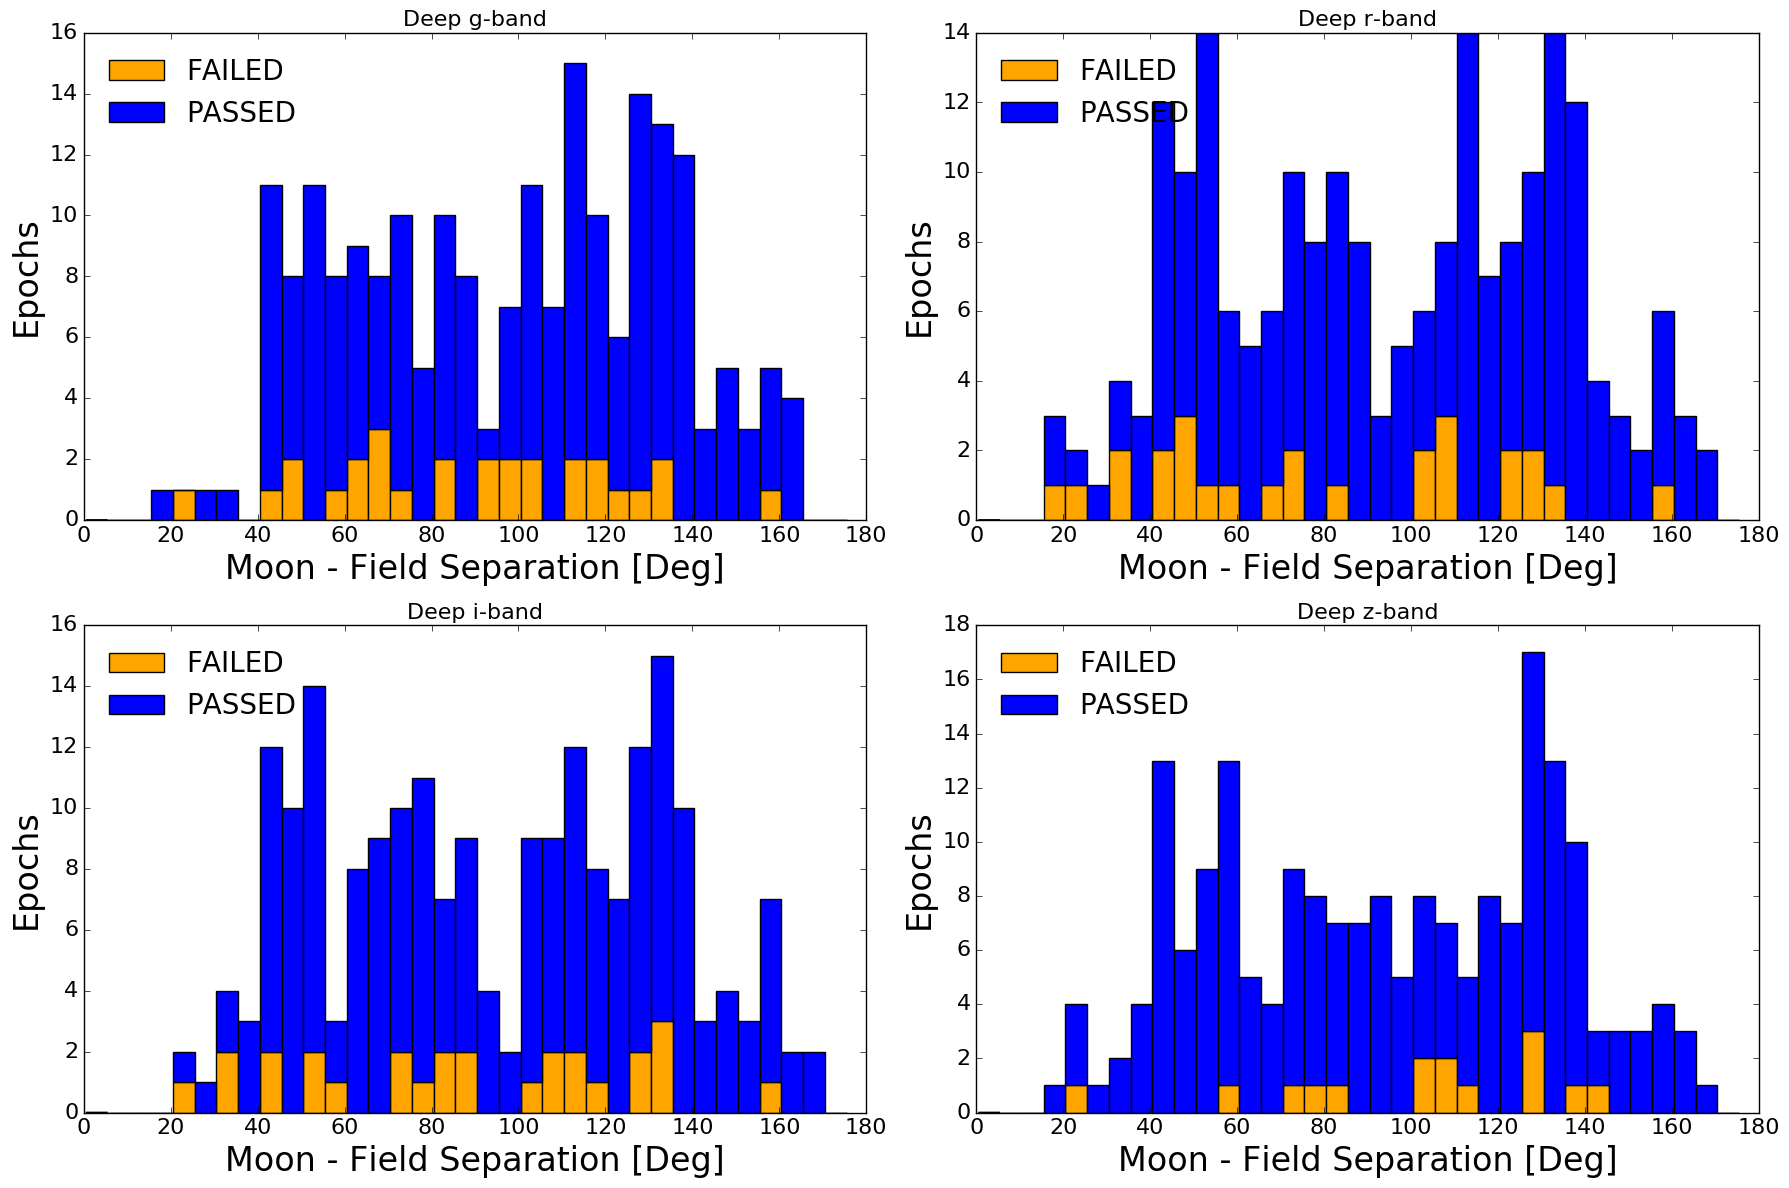

In [29]:
f, ax1 = plt.subplots(2,2, figsize=(18,12))

t1 = new_data.query("ACCEPT != 'True'")
t2 = new_data.query("ACCEPT == 'True'")

ax2 = ax1.flatten()
band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    color = band[i]

    temp2 = t2.query("BAND_qual == '{0}' and (FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3')".format(color))
    temp1 = t1.query("BAND_qual == '{0}' and (FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3')".format(color))
    
    ax.hist([temp1['MOONDIST'], temp2['MOONDIST']], bins=np.arange(0,180,5), color=['orange','blue'], \
            label=['FAILED','PASSED'], stacked='True', width=5.0)
 
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel('Moon - Field Separation [Deg]',fontsize=24)
    ax.set_ylabel('Epochs',fontsize=24)

    ax.legend(loc='upper left',frameon=False,fontsize=20)
    ax.set_title('Deep {0}-band'.format(color),fontsize=16)

plt.tight_layout()
plt.show()

888
4036


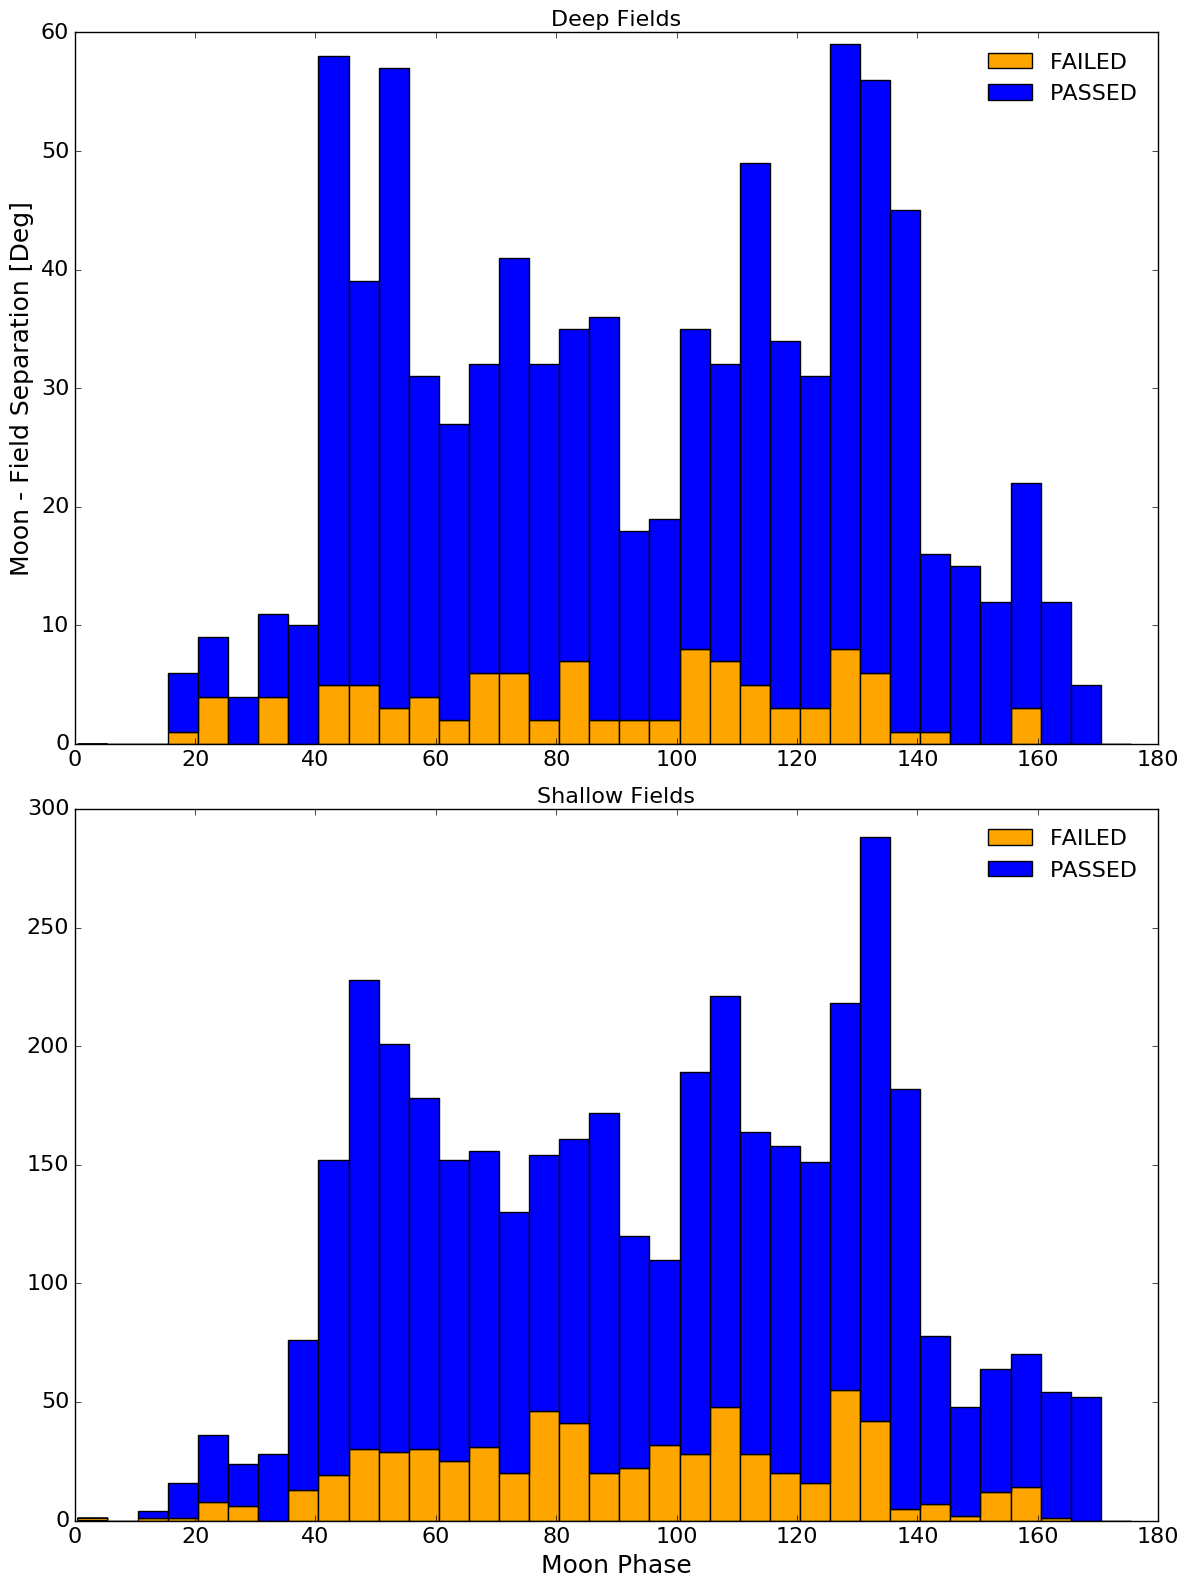

In [30]:
f, [ax1, ax2] = plt.subplots(2,1, figsize=(12,16))

t1 = new_data.query("ACCEPT != 'True'")
t2 = new_data.query("ACCEPT == 'True'")

temp2_1 = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
temp1_1 = t1.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
print len(temp2_1)+len(temp1_1)

temp2_2 = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")
temp1_2 = t1.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")
print len(temp2_2)+len(temp1_2)

ax1.hist([temp1_1['MOONDIST'], temp2_1['MOONDIST']], bins=np.arange(0,180,5), color=['orange','blue'], \
            label=['FAILED','PASSED'], stacked='True', width=5.0)
ax2.hist([temp1_2['MOONDIST'], temp2_2['MOONDIST']], bins=np.arange(0,180,5), color=['orange','blue'], \
            label=['FAILED','PASSED'], stacked='True', width=5.0)
 

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('Moon - Field Separation [Deg]',fontsize=18)
ax2.set_xlabel('Moon Phase',fontsize=18)
ax1.set_ylabel('Moon - Field Separation [Deg]',fontsize=18)
ax2.set_xlabel('Moon Phase',fontsize=18)

ax1.legend(loc='upper right',frameon=False,fontsize=16)
ax2.legend(loc='upper right',frameon=False,fontsize=16)
ax1.set_title('Deep Fields'.format(color),fontsize=16)
ax2.set_title('Shallow Fields'.format(color),fontsize=16)

plt.tight_layout()
plt.show()

In [31]:
bright

NameError: name 'bright' is not defined

### ANSWER:  We can use all data.  

20140109 had 1.3" seeing, and was 16 degrees away from 70% illuminated moon.  It passed DQ

In [ ]:
#Eric asked for the above plots broken down by sequence type

---

In [ ]:
#See what the depth is in our DES-SN fields as a function of time
#matplotlib.style.use('ggplot')

f, ax1 = plt.subplots(1, figsize=(16,9))
matplotlib.style.use('ggplot')

#Just select C3, Y4
t = new_data.query("FIELD_qual == 'SN-C3' and \
                    NITE_qual > 20160606 and NITE_qual < 20170606 and \
                    EFF50 < 28 and ACCEPT == 'True'" )
t = t.sort_values(by='MJD_OBS')

mpl.rcParams['lines.linewidth'] = 3

ax1 = t.query("BAND_qual == 'g'").plot(x='MJD_OBS',y='EFF50',color='blue', ax=ax1, \
                                       label='g', marker='o', markersize='9')
t.query("BAND_qual == 'r'").plot(x='MJD_OBS',y='EFF50',color='green', ax=ax1, label='r', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'i'").plot(x='MJD_OBS',y='EFF50',color='orange', ax=ax1, label='i', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'z'").plot(x='MJD_OBS',y='EFF50',color='brown', ax=ax1, label='z', \
                                marker='o', markersize='9')

ax1.set_title('C3-Y4 Depth',fontsize=24)
ax1.set_ylim(26,22.5)
#t.plot(x='MJD_OBS',y='EFF50',color='green')
#t.plot(x='MJD_OBS',y='EFF50',color='orange')
#t.plot(x='MJD_OBS',y='EFF50',color='brown')
plt.show()



In [ ]:
#See what the depth is in our DES-SN fields as a function of time
#matplotlib.style.use('ggplot')

fields = ['SN-S1','SN-S2','SN-C1','SN-C2','SN-C3','SN-E1','SN-E2','SN-X1','SN-X2','SN-X3']
f, ax1 = plt.subplots(1,10, figsize=(16,90))
matplotlib.style.use('ggplot')

ax2 = ax1.flatten()

for i,item in enumerate(ax2):
#Just select C3, Y4
    t = new_data.query("FIELD_qual == '{0}' and \
                        NITE_qual > 20160606 and NITE_qual < 20170606 and \
                        EFF50 < 28 and ACCEPT == 'True'".format(fields[i]) )
    t = t.sort_values(by='MJD_OBS')

    mpl.rcParams['lines.linewidth'] = 3

    ax1 = t.query("BAND_qual == 'g'").plot(x='MJD_OBS',y='EFF50',color='blue', ax=ax1, \
                                       label='g', marker='o', markersize='9')
t.query("BAND_qual == 'r'").plot(x='MJD_OBS',y='EFF50',color='green', ax=ax1, label='r', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'i'").plot(x='MJD_OBS',y='EFF50',color='orange', ax=ax1, label='i', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'z'").plot(x='MJD_OBS',y='EFF50',color='brown', ax=ax1, label='z', \
                                marker='o', markersize='9')

ax1.set_title('C3-Y4 Depth',fontsize=24)
ax1.set_ylim(26,22.5)
#t.plot(x='MJD_OBS',y='EFF50',color='green')
#t.plot(x='MJD_OBS',y='EFF50',color='orange')
#t.plot(x='MJD_OBS',y='EFF50',color='brown')
plt.show()



In [ ]:
new_data.columns

In [ ]:
f, ax1 = plt.subplots(2,2, figsize=(18,16))
ax2 = ax1.flatten()

t2 = new_data.query("ACCEPT == 'True'")

deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")

band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    flt = band[i]
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    ax.hist([t2['EFF50'], t1['EFF50']], \
            bins=np.arange(21,26,0.2), color=['orange','blue'], \
            label=['DEEP ({0})'.format(t2['EFF50'].median()),'SHALLOW ({0})'.format(t1['EFF50'].median())], \
            stacked='True', width=0.2) 

    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_ylabel('FILTER EPOCHS',fontsize=18)
    ax.set_xlabel('DEPTH (50% efficiency)',fontsize=18)

    ax.legend(loc='upper left',frameon=False,fontsize=16)
    ax.set_title('{0}-band'.format(flt),fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
band = ['g', 'r', 'i', 'z']
for j, item in enumerate(band):
    print '--------------{}------------'.format(item)
    temp = []
    t1 = shallow.query("BAND_qual == '{0}'".format(item))
    ll = len(t1)
    for i in np.arange(21.0,25.0,0.1):
        t2 = shallow.query("BAND_qual == '{0}' and EFF50 < {1}".format(item,i))
        temp.append([i,1.0*len(t2)/ll])

    for item in temp:
        print item[0],item[1]
        
    

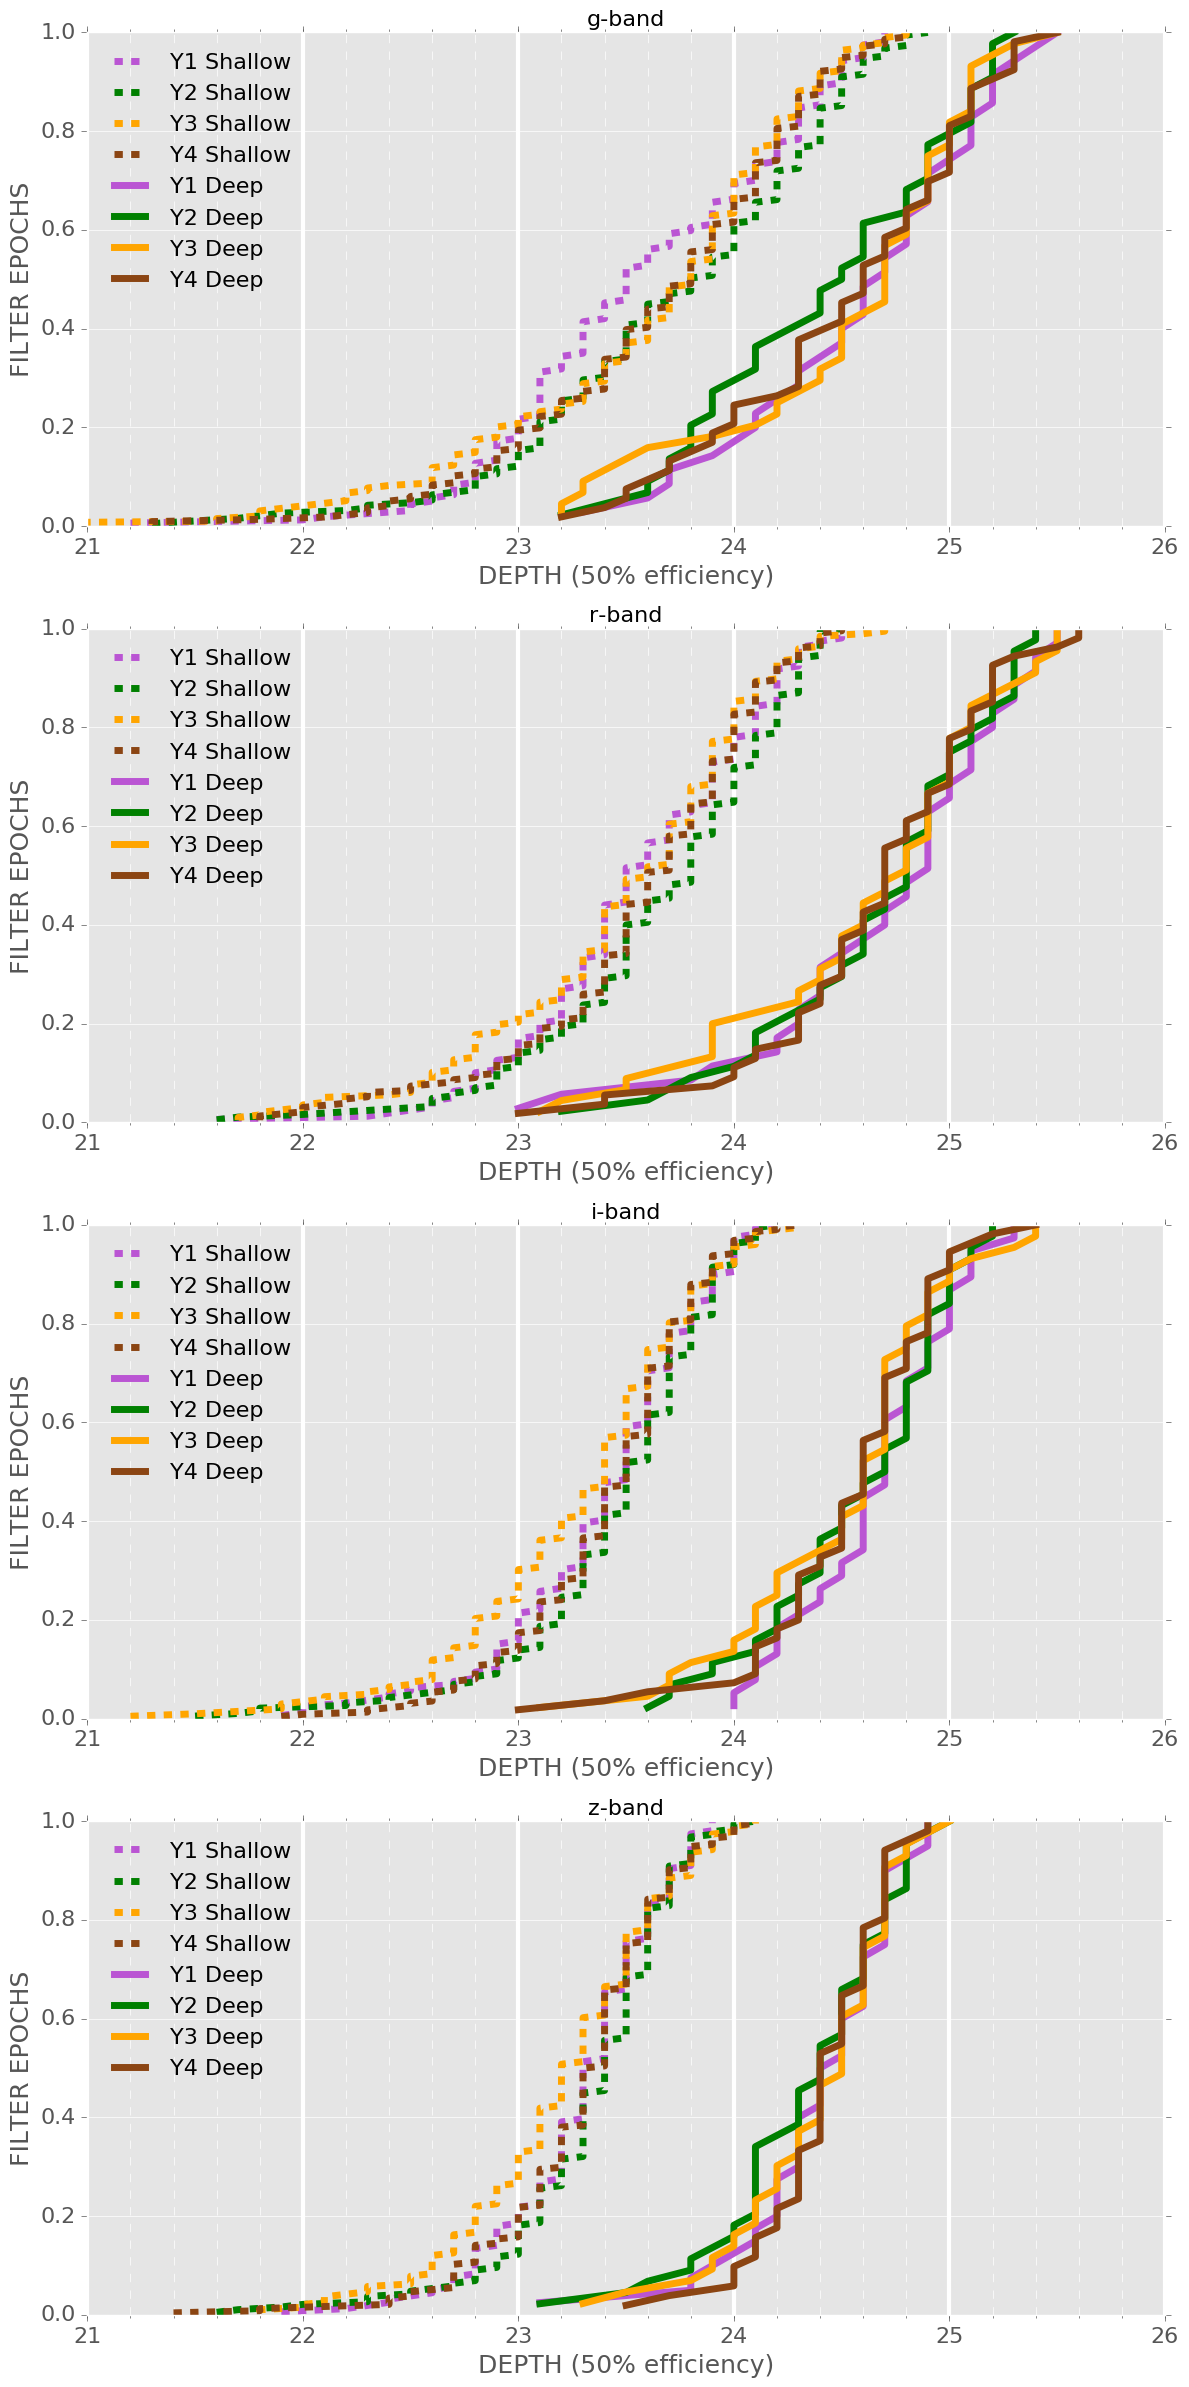

In [40]:
f, ax1 = plt.subplots(4,1, figsize=(12,24))
ax2 = ax1.flatten()

mpl.style.use('ggplot')


t2 = data.query("ACCEPT == 'True'")

deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5

for i,ax in enumerate(ax2):
    NITE_LOW  = '201{0}0606'
    NITE_HIGH = '201{0}0606'
    
    flt = band[i]
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    for j in range(4):
        x1 = t1.query("NITE_qual > 201{0}0606 and NITE_qual < 201{1}0606".format(j+3,j+4)).sort_values(by='EFF50')
        y1 = 1.0+np.arange(1.0*len(x1))
        
        ax.plot(x1['EFF50'],y1/len(x1),color=colors[j],linestyle='dashed',label = 'Y{0} Shallow'.format(j+1))
        
    for j in range(4):
        x2 = t2.query("NITE_qual > 201{0}0606 and NITE_qual < 201{1}0606".format(j+3,j+4)).sort_values(by='EFF50')
        y2 = 1.0+np.arange(1.0*len(x2))
        
        ax.plot(x2['EFF50'],y2/len(x2),color=colors[j],linestyle='solid',label = 'Y{0} Deep'.format(j+1))
        

    ax.tick_params(axis='both', which='major', labelsize=16)

    xminorLocator = MultipleLocator(0.2)
    #ax1.xaxis.set_major_locator(xmajorLocator)
    #ax1.xaxis.set_major_formatter(xmajorFormatter)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.grid(which='minor', axis='x', linestyle='--')
    ax.grid(which='major', axis='x', linestyle='-',linewidth=3)

    #yminorLocator = AutoMinorLocator()
    #ax1.yaxis.set_minor_locator(yminorLocator)
    
    
    ax.set_ylabel('FILTER EPOCHS',fontsize=18)
    ax.set_xlabel('DEPTH (50% efficiency)',fontsize=18)

    ax.set_xlim(21,26)
    
    ax.legend(loc='upper left',frameon=False,fontsize=16)
    ax.set_title('{0}-band'.format(flt),fontsize=16)

plt.tight_layout()
plt.show()

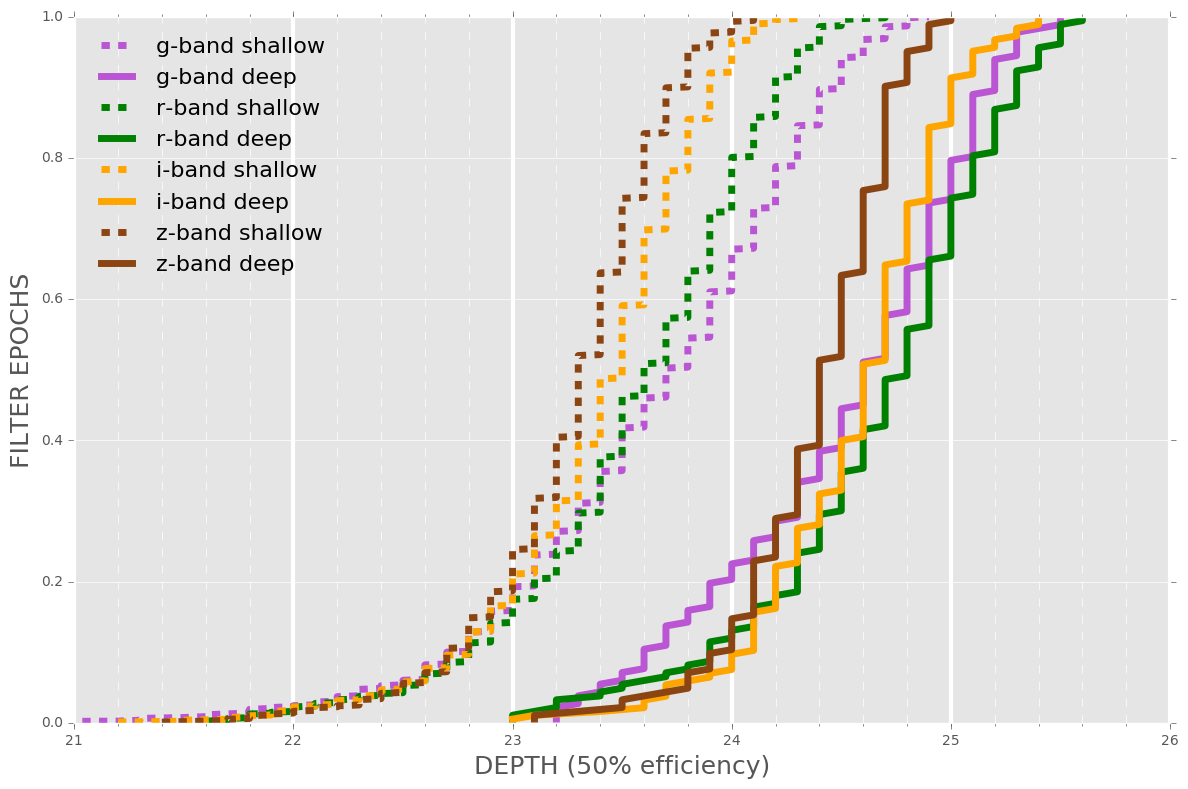

In [46]:
f, ax1 = plt.subplots(1, figsize=(12,8))

t2 = new_data.query("ACCEPT == 'True'")

deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5

for i,item in enumerate(band):
    flt = item
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    x1 = t1.query("NITE_qual > 20130606").sort_values(by='EFF50')
    y1 = 1.0+np.arange(1.0*len(x1))
    ax1.plot(x1['EFF50'],y1/len(x1),color=colors[i],linestyle='dashed',label = '{0}-band shallow'.format(flt))
        
    x2 = t2.query("NITE_qual > 20130606").sort_values(by='EFF50')
    y2 = 1.0+np.arange(1.0*len(x2))    
    ax1.plot(x2['EFF50'],y2/len(x2),color=colors[i],linestyle='solid',label = '{0}-band deep'.format(flt))
        

    ax.tick_params(axis='both', which='major', labelsize=16)

    xminorLocator = MultipleLocator(0.2)
    #ax1.xaxis.set_major_locator(xmajorLocator)
    #ax1.xaxis.set_major_formatter(xmajorFormatter)
    ax1.xaxis.set_minor_locator(xminorLocator)
    ax1.grid(which='minor', axis='x', linestyle='--')
    ax1.grid(which='major', axis='x', linestyle='-',linewidth=3)

    #yminorLocator = AutoMinorLocator()
    #ax1.yaxis.set_minor_locator(yminorLocator)
    
    
    ax1.set_ylabel('FILTER EPOCHS',fontsize=18)
    ax1.set_xlabel('DEPTH (50% efficiency)',fontsize=18)

    ax1.set_xlim(21,26)
    
    ax1.legend(loc='upper left',frameon=False,fontsize=16)
  
plt.tight_layout()
plt.show()